# Import libraries

In [1]:
import numpy as np
import uproot as up
import awkward as ak
from matplotlib import pyplot as plt
from scipy.stats import binned_statistic_dd
import pandas as pd
import mplhep as hep
hep.style.use("CMS")

# Load data

In [2]:
class Jet:
    
    def __init__(self, path, ptvar, etavar, branch="outnano/Jets"):
        self.data = up.open(path)[branch]
        self.ptvar = ptvar
        self.etavar = etavar
        
    def load(self):
        print(f"Loading L1 data with pt == {self.ptvar} and eta == {self.etavar}...")
        self.l1 = np.array( [self.data[f"jet_{self.ptvar}"].array(), self.data[f"jet_{self.etavar}"].array(), self.data["jet_mass"].array()] ).T
        print(f"L1 data loaded.\n")
        
        print(f"Loading gen data...")
        self.gen = np.array( [self.data["jet_genmatch_pt"].array(), self.data["jet_genmatch_eta"].array(), self.data["jet_genmatch_mass"].array(), self.data["event"]] ).T
        print(f"Gen data loaded.\n")
        
        print(f"Rejecting jets marked as bad...")
        reject_mask = self.data["jet_reject"].array() == False
        self.l1, self.gen = self.l1[reject_mask], self.gen[reject_mask]
        print(f"Rejected { np.sum( reject_mask == False ) } jets marked as bad.")
        
        self.total = len(self.l1)
        self.nJets = self.total
        self.isShuffled = False
        print(f"Total jets = {self.total}\n\n")
        return self.l1, self.gen

    def filterUnmatched(self):
        """ Removed unmatched jets """
        genmatch_mask = (self.gen[:, 0] > 0) & (self.gen[:, 2] > 0)
        print(f"Removing {self.total - np.sum(genmatch_mask)} unmatched jets in dataset...")
        self.l1, self.gen = self.l1[genmatch_mask], self.gen[genmatch_mask]
        print(f"{len(self.gen)} jets remaining in dataset\n\n")
        self.nJets = np.sum(genmatch_mask)
        return self.l1, self.gen

    def l1cuts(self, ptcut = 0, etacut = 5.0, masscut = 0):
        """ Apply basic kinematic cuts """
        cuts_mask = (self.l1[:, 0] > ptcut) & (np.abs(self.l1[:, 1]) < etacut) & (self.l1[:, 2] > masscut)
        print(f"Removing {self.nJets - np.sum(cuts_mask)} jets due to level-1 cuts...")
        self.l1, self.gen = self.l1[cuts_mask], self.gen[cuts_mask]
        print(f"{len(self.gen)} jets remaining in dataset.\n\n")
        return self.l1, self.gen
    
    def preprocess(self):
        mask = self.gen[:,2] > 1
        self.l1, self.gen = self.l1[mask], self.gen[mask]
        self.l1[:, 2] = np.clip(self.l1[:, 2], 0, 256)
        
    def shuffle(self):
        print(f"Shuffling jets...")
        shuffle = np.random.permutation(len(self.l1))
        self.l1, self.gen = self.l1[shuffle], self.gen[shuffle]
        self.isShuffled = True
        print(f"Jets shuffled.\n\n")
        return self.l1, self.gen
    
    def split(self, train_ratio = 0.75):
        print(f"Splitting jets into training and testing samples...")
        splitIdx = int(len(self.l1) * train_ratio)
        self.l1_train, self.l1_test = self.l1[:splitIdx], self.l1[splitIdx:]
        self.gen_train, self.gen_test = self.gen[:splitIdx], self.gen[splitIdx:]
        print(f"Allocated {len(self.l1_train)} jets for training, and {len(self.l1_test)} jets for testing\n\n")
        return self.l1_train, self.l1_test, self.gen_train, self.gen_test
    
    def response(self):
        print(f"Calculating pT and mass response...")
        pt_response = self.l1_train[:,0] / self.gen_train[:,0]
        mass_response = self.l1_train[:,2] / self.gen_train[:,2]
        self.l1_train = np.hstack([self.l1_train, pt_response[:,None], mass_response[:,None]])
        print(f"pT and mass response calculated and appended to data.\n")
    
    def histogram(self, nBins=101, nan=1):
        bins = [nBins, nBins, nBins]
        print("Binning with respect to gen pT, eta and mass, with bins populated with mean pT response and mean mass response...")
        pt_resp, _, _ = binned_statistic_dd( self.l1_train[:, [0,1,2]], self.l1_train[:, 3], statistic='median', bins = bins )
        mass_resp, edges, _ = binned_statistic_dd( self.l1_train[:, [0,1,2]], self.l1_train[:, 4], statistic='median', bins = bins )
        print("Binning complete.\n")
        
        print(f"Calculating scale factors from mean response, imputing 1 for nans...")
        self.pt_sf = 1 / np.nan_to_num(pt_resp, nan=nan)
        self.mass_sf = 1 / np.nan_to_num(mass_resp, nan=nan)
        self.bin_edges = edges
        
        print(f"Scale factors saved.\n\n")
        return pt_resp, mass_resp, edges
    
    def applyScaleFactors(self):
        print(f"Applying scale factors to get corrected pT and mass...")
        bin_idx = [np.digitize(self.l1_test[:, i], self.bin_edges[i]) - 1 for i in range(3)]    # assume first three indices are pt, eta and mass
        bin_idx = np.stack(bin_idx, axis=-1)

        # check that jet falls into a valid, predefined bin
        valid = np.all( [(0 <= bin_idx[:, i]) & (bin_idx[:, i] < len(self.bin_edges[i]) - 1) for i in range(3)], axis=0 )

        # initialize output and assign values from mean_values
        pt_output, mass_output = np.ones( len(self.l1_test) ), np.ones( len(self.l1_test) )
        pt_output[valid] = self.pt_sf[ tuple(bin_idx[valid].T) ]    # where jet falls into a valid bin, assign the scale factor
        mass_output[valid] = self.mass_sf[ tuple(bin_idx[valid].T) ]    # where jet falls into a valid bin, assign the scale factor
        
        pt_corr = self.l1_test[:,0] * pt_output
        mass_corr = self.l1_test[:,2] * mass_output
        
        self.l1_test = np.hstack( [self.l1_test, pt_corr[:,None], mass_corr[:,None]] )
        print(f"Corrected pT and mass saved.\n\n")
        return pt_corr, mass_corr
    
    def save(self):
        print(f"Producing a dataframe from test data...")
        d = np.hstack([self.l1_test[:, [0,3,2,4]], self.gen_test[:, [0,2,3]]])
        self.df = pd.DataFrame(data=d, columns=["reco_pt", "corr_pt", "reco_mass", "corr_mass", "gen_pt", "gen_mass", "event"])
        print("Dataframe produced.\n\n")
        return self
        
    def pipeline(self, ):
        self.load()
        self.filterUnmatched()
        self.l1cuts()
        self.preprocess()
        self.shuffle()
        self.split()
        self.response()
        self.histogram()
        self.applyScaleFactors()
        self.save()
        return self.df

In [3]:
def binResp(df, var):
    if var == "pt":
        gen = df["gen_pt"]
        reco_resp, corr_resp = df["reco_pt"] / gen, df["corr_pt"] / gen
        bins = np.linspace(0, 500, 101)
    elif var == "mass":
        gen = df["gen_mass"]
        reco_resp, corr_resp = df["reco_mass"] / gen, df["corr_mass"] / gen
        bins = np.linspace(0, 180, 101)
    else:
        raise Exception("Invalid variable!")

    reco_mean, reco_stddev = [], []
    corr_mean, corr_stddev = [], []
    for b in range( len(bins) - 1 ):
        mask = (gen >= bins[b]) & (gen < bins[b+1])
        recoInBin, corrInBin = reco_resp[mask], corr_resp[mask]

        reco_mean.append( np.mean(recoInBin) )
        reco_stddev.append( np.var(recoInBin, ddof=1) )

        corr_mean.append( np.mean(corrInBin) )
        corr_stddev.append( np.var(corrInBin, ddof=1) )

    return reco_mean, reco_stddev, corr_mean, corr_stddev, bins


def plotResp(df, var = ["pt", "mass"]):
    _, axes = plt.subplots(2, max(len(var),2), figsize=(21.60, 14.4))
    for i, v in enumerate(var):
        mean_ax, std_ax = axes[i]
        reco_mean, reco_stddev, corr_mean, corr_stddev, bins = binResp(df, v)
        xs = ((bins/2)[1] + bins)[:-1]

        std_ax.errorbar(xs, reco_stddev, label=f"Reco {v}", fmt="-", capsize=5)
        std_ax.errorbar(xs, corr_stddev, label=f"Corr {v}", fmt="-", capsize=5)
        std_ax.set_xlabel(f"{v}"+"$_{gen} (GeV)$", fontsize=20); std_ax.set_ylabel("$\sigma^2( \\frac{L1}{Gen} )$", fontsize=20)

        mean_ax.errorbar(xs, reco_mean, label=f"Reco {v}", fmt="-", capsize=5)    # plot reco bias
        mean_ax.errorbar(xs, corr_mean, label=f"Corr {v}", fmt="-", capsize=5)    # plot corr bias
        mean_ax.set_xlabel(f"{v}"+"$_{gen}$ (GeV)", fontsize=20); mean_ax.set_ylabel("$\mu( \\frac{L1}{Gen} )$", fontsize=20)

        std_ax.axhline(0, color="black", linestyle="--", label="Pefect variance")
        std_ax.set_xlim([bins[0], bins[-1]]); std_ax.set_ylim([-0.05, 1.05])
        std_ax.set_xticks(bins[::10]); std_ax.set_yticks(np.linspace(-0, 1, 11))
        std_ax.grid()
        std_ax.legend()
        hep.cms.label(ax=std_ax, llabel="Phase-2 Simulation Preliminary", rlabel="200 PU (14 TeV)", fontsize=21)
        
        mean_ax.axhline(1, color="black", linestyle="--", label="Perfect bias")
        mean_ax.set_xlim([bins[0], bins[-1]]); mean_ax.set_ylim([0,2])
        mean_ax.set_xticks(bins[::10]); mean_ax.set_yticks(np.linspace(0,2,11))
        mean_ax.grid()
        mean_ax.legend()
        hep.cms.label(ax=mean_ax, llabel="Phase-2 Simulation Preliminary", rlabel="200 PU (14 TeV)", fontsize=21)

    plt.show()

In [ ]:
path = "./data/sc8Jets.root"

In [5]:
jets = Jet(path, "pt", "eta_phys")
df = jets.pipeline()

Loading L1 data with pt == pt and eta == eta_phys...
L1 data loaded.

Loading gen data...
Gen data loaded.

Rejecting jets marked as bad...
Rejected 18462 jets marked as bad.
Total jets = 7815073


Removing 1679286 unmatched jets in dataset...
6135787 jets remaining in dataset


Removing 148506 jets due to level-1 cuts...
5987281 jets remaining in dataset.


Shuffling jets...
Jets shuffled.


Splitting jets into training and testing samples...
Allocated 4482261 jets for training, and 1494088 jets for testing


Calculating pT and mass response...
pT and mass response calculated and appended to data.

Binning with respect to gen pT, eta and mass, with bins populated with mean pT response and mean mass response...
Binning complete.

Calculating scale factors from mean response, imputing 1 for nans...
Scale factors saved.


Applying scale factors to get corrected pT and mass...
Corrected pT and mass saved.


Producing a dataframe from test data...
Dataframe produced.




In [ ]:
df

,reco_pt,corr_pt,reco_mass,corr_mass,gen_pt,gen_mass,event
0,1628.00,1628.000000,181.018646,181.018646,1658.436890,252.320053,156297.0
1,137.75,153.754524,39.790073,52.843797,161.598816,50.935997,387650.0
2,403.75,352.237690,50.346302,50.994409,472.456573,99.123917,319053.0
3,192.75,193.030391,15.411035,31.490980,203.573578,38.837173,263013.0
4,163.00,171.546767,20.663979,35.967281,161.768127,20.046040,170195.0
...,...,...,...,...,...,...,...
1494083,12.00,18.345713,2.549510,9.665753,28.609734,15.428939,58777.0
1494084,566.00,559.187956,134.591980,131.931542,557.870544,101.187271,89226.0
1494085,169.25,173.047550,1.500000,22.827574,166.314941,25.373442,360441.0
1494086,109.50,133.612614,34.445610,58.592759,168.577011,69.716904,386819.0


# Produce response plots

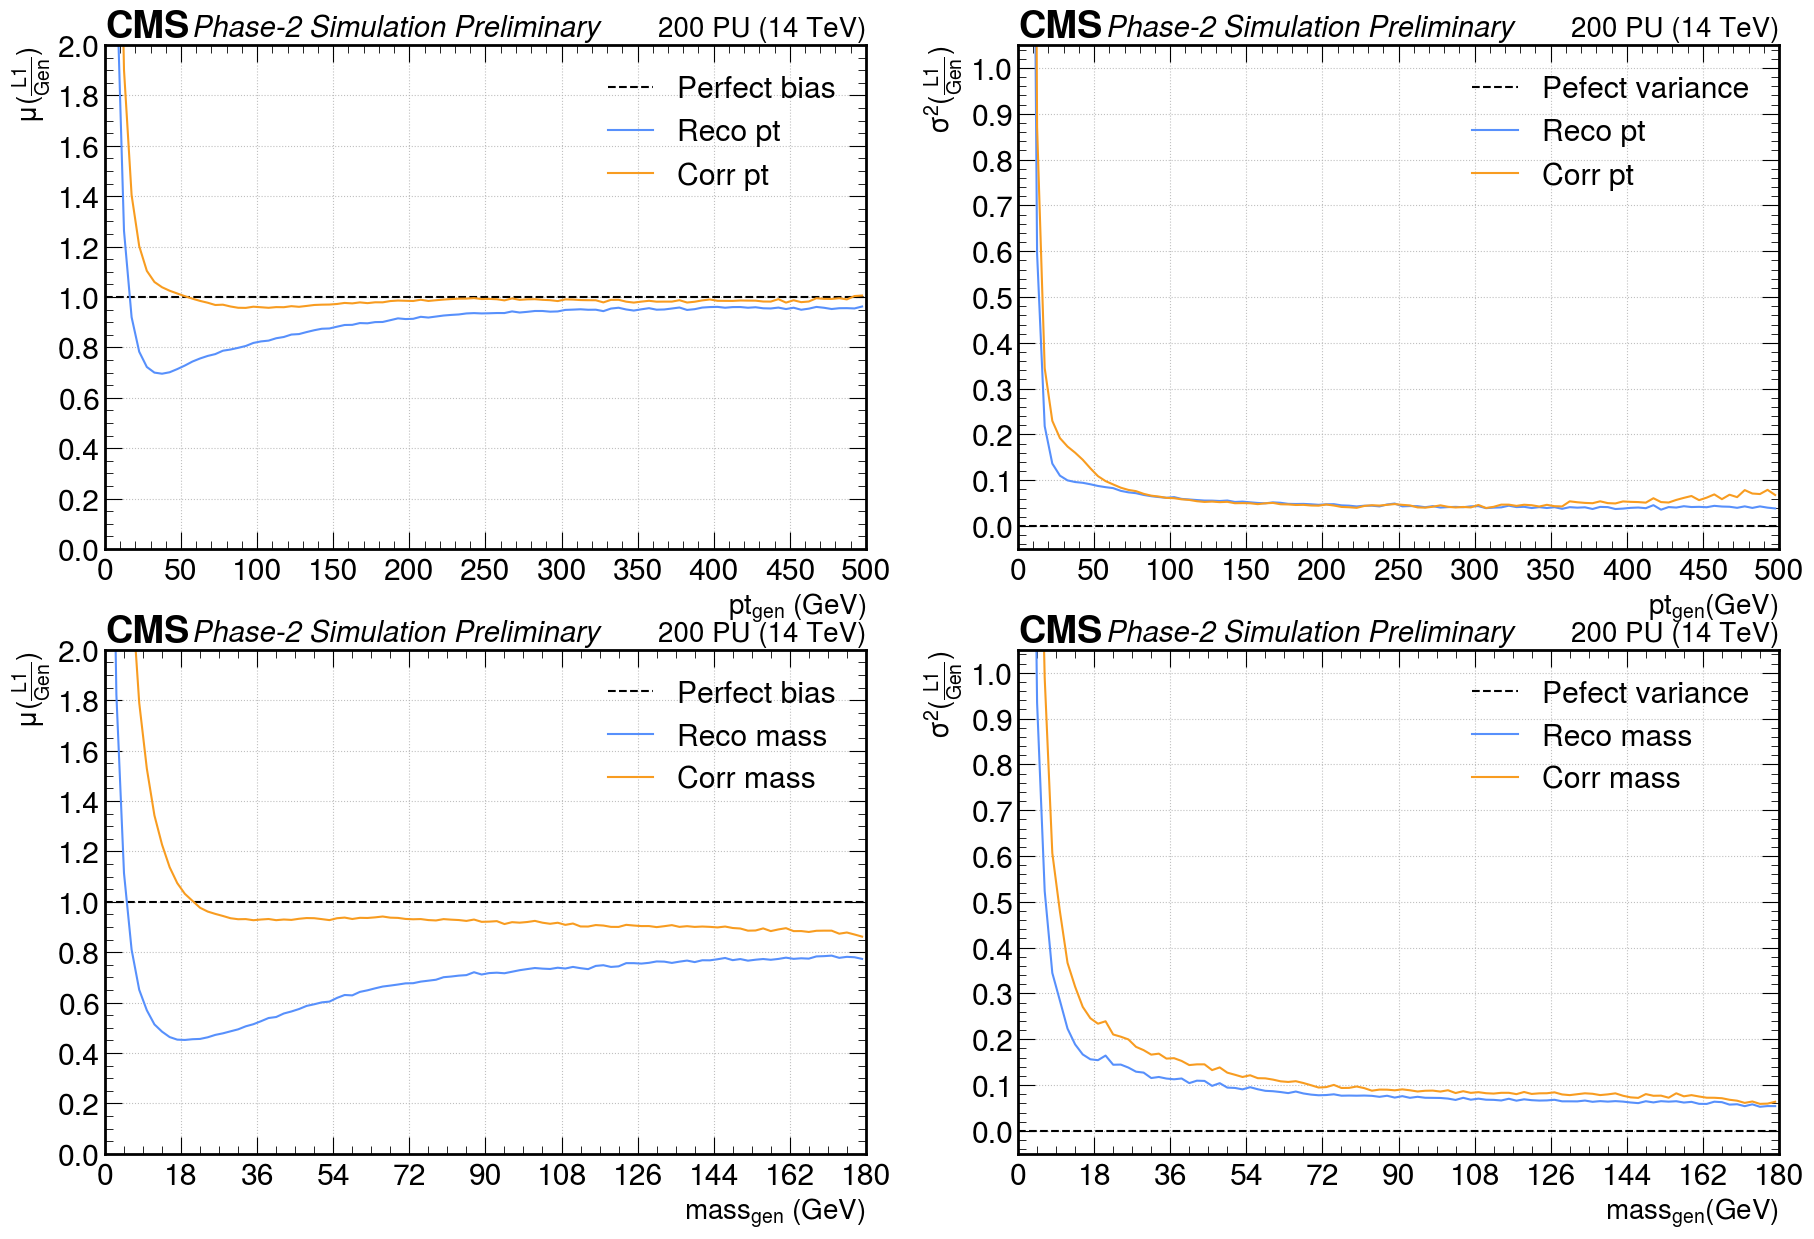

In [7]:
plotResp(df)

# Test performance after applying corrections

In [ ]:
tt_path = "./data/TT_PU200.root"
tt = up.open(tt_path + ":outnano/Jets").arrays(filter_name=["event", "jet_pt", "jet_eta", "jet_mass"])

In [ ]:
tt_jets = Jet(tt_path, "pt", "eta_phys")

In [ ]:
tt_jets.load()

Loading L1 data with pt == pt and eta == eta_phys...
L1 data loaded.

Loading gen data...
Gen data loaded.

Rejecting jets marked as bad...
Rejected 3663 jets marked as bad.
Total jets = 1633834




(array([[ 5.9500000e+01,  1.0868254e+00,  5.0744457e+00],
        [ 5.5500000e+01,  1.4572818e+00,  1.9435791e+01],
        [ 4.5500000e+01,  2.1475732e-02,  6.4807405e+00],
        ...,
        [ 8.2250000e+01, -6.0208750e-01,  1.1180340e+00],
        [ 6.8250000e+01,  2.1030877e+00,  1.8708287e+00],
        [ 1.3000000e+01,  4.6709716e-01,  4.0000000e+00]], dtype=float32),
 array([[ 7.48984070e+01,  1.08570123e+00,  1.88406544e+01,
          1.23007000e+05],
        [ 1.04394257e+02,  1.39611602e+00,  2.89913616e+01,
          1.23007000e+05],
        [ 5.95109749e+01,  8.65622610e-02,  1.63642693e+01,
          1.23007000e+05],
        ...,
        [ 8.25055008e+01, -6.09568655e-01,  1.62085571e+01,
          2.51998000e+05],
        [ 9.25609512e+01,  2.14248943e+00,  1.94703541e+01,
          2.51998000e+05],
        [ 2.93079987e+01,  5.06227791e-01,  1.16099844e+01,
          2.51998000e+05]]))

In [ ]:
tt_jets

In [ ]:
# groupby event
sorted_arr = tt[ak.argsort(tt.event)]
counts = ak.run_lengths(sorted_arr.event)
tt_grouped = ak.unflatten(sorted_arr, counts)

In [ ]:
def applyScaleFactors_awkward(jets, bin_edges, pt_sf, mass_sf):
    """
    jets: awkward array with fields jet_pt, jet_eta, jet_mass
    bin_edges: list/tuple of 3 arrays [pt_edges, eta_edges, mass_edges]
    pt_sf, mass_sf: 3D numpy arrays of scale factors with shape
                    (n_pt_bins, n_eta_bins, n_mass_bins)
    """

    # ---- STEP 1: Extract numpy views of the awkward fields ----
    pt   = ak.to_numpy(jets["jet_pt"])
    eta  = ak.to_numpy(jets["jet_eta"])
    mass = ak.to_numpy(jets["jet_mass"])

    # ---- STEP 2: Find bin indices along each axis ----
    # np.digitize returns indices 1..N, so subtract 1 for 0-based indexing
    pt_idx   = np.digitize(pt,   bin_edges[0]) - 1
    eta_idx  = np.digitize(eta,  bin_edges[1]) - 1
    mass_idx = np.digitize(mass, bin_edges[2]) - 1

    bin_idx = np.stack([pt_idx, eta_idx, mass_idx], axis=-1)

    # ---- STEP 3: Validity mask: jet must be inside all defined bins ----
    valid = (
        (bin_idx[:,0] >= 0) & (bin_idx[:,0] < len(bin_edges[0]) - 1) &
        (bin_idx[:,1] >= 0) & (bin_idx[:,1] < len(bin_edges[1]) - 1) &
        (bin_idx[:,2] >= 0) & (bin_idx[:,2] < len(bin_edges[2]) - 1)
    )

    # ---- STEP 4: Allocate outputs ----
    pt_output   = np.ones(len(pt))
    mass_output = np.ones(len(pt))

    # ---- STEP 5: Fill valid bins with scale factors ----
    pt_output[valid] = pt_sf   [bin_idx[valid,0], bin_idx[valid,1], bin_idx[valid,2]]
    mass_output[valid] = mass_sf[bin_idx[valid,0], bin_idx[valid,1], bin_idx[valid,2]]

    # ---- STEP 6: Apply corrections ----
    pt_corr   = pt   * pt_output
    mass_corr = mass * mass_output

    # ---- STEP 7: Append corrected values as new fields ----
    jets = jets.assign(
        pt_corr   = pt_corr,
        mass_corr = mass_corr,
        pt_sf     = pt_output,
        mass_sf   = mass_output,
        valid_bin = valid
    )

    return jets


In [ ]:
applyScaleFactors_awkward(tt, )

TypeError: applyScaleFactors_awkward() missing 3 required positional arguments: 'bin_edges', 'pt_sf', and 'mass_sf'

In [ ]:
# gen_mass = pt_df.gen_mass
mass_resp = (pt_df.reco_mass+10.33) / pt_df.gen_mass
mass_resp_corr = (pt_df.corr_mass+10.33) / pt_df.gen_mass



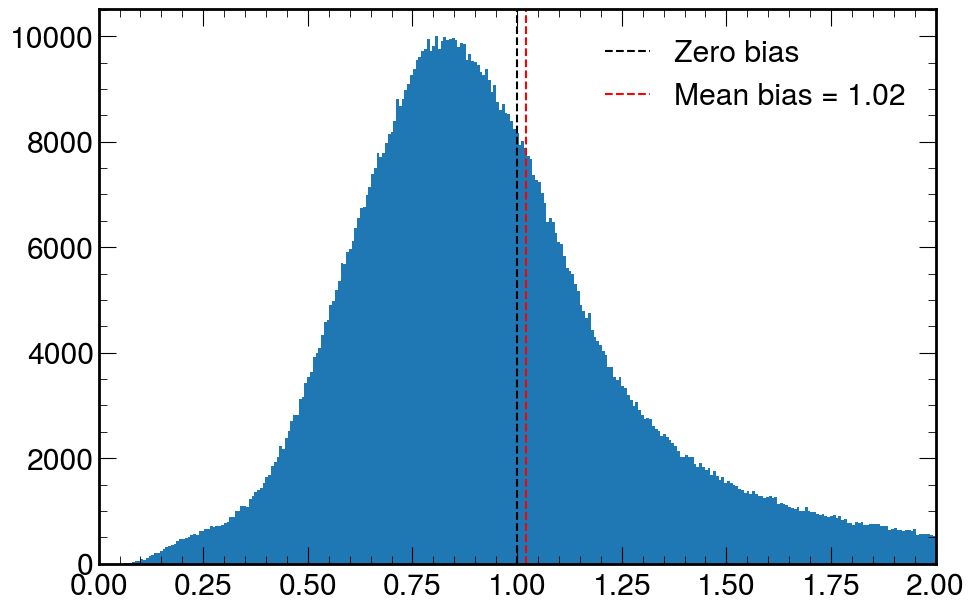

In [ ]:
plt.figure(figsize=(10.8, 7.2))
plt.hist(mass_resp, bins=301, range=[0,2])

plt.axvline(1, color="black", linestyle="--", label="Zero bias")
plt.axvline(np.mean(mass_resp), color="red", linestyle="--", label=f"Mean bias = {np.mean(mass_resp):.2f}")
# plt.axvline(np.median(mass_resp), color="orange", linestyle="-.", label=f"Median bias = {np.mean(mass_resp):.2f}")

plt.legend()
plt.xlim([0,2])
plt.show()

In [ ]:
ptraw = Jet(path, "pt_raw", "eta_phys")
ptraw_df = ptraw.pipeline()

Loading L1 data with pt == pt_raw and eta == eta_phys...
L1 data loaded.

Loading gen data...
Gen data loaded.

Rejecting jets marked as bad...
Rejected 18462 jets marked as bad.
Total jets = 7815073


Removing 2102690 unmatched jets in dataset...
5712383 jets remaining in dataset


Removing 1347175 jets due to level-1 cuts...
4365208 jets remaining in dataset.


Shuffling jets...
Jets shuffled.


Splitting jets into training and testing samples...
Allocated 3273906 jets for training, and 1091302 jets for testing


Calculating pT and mass response...
pT and mass response calculated and appended to data.

Binning with respect to gen pT, eta and mass, with bins populated with mean pT response and mean mass response...
Binning complete.

Calculating scale factors from mean response, imputing 1 for nans...
Scale factors saved.


Applying scale factors to get corrected pT and mass...
Corrected pT and mass saved.


Producing a dataframe from test data...
Dataframe produced.




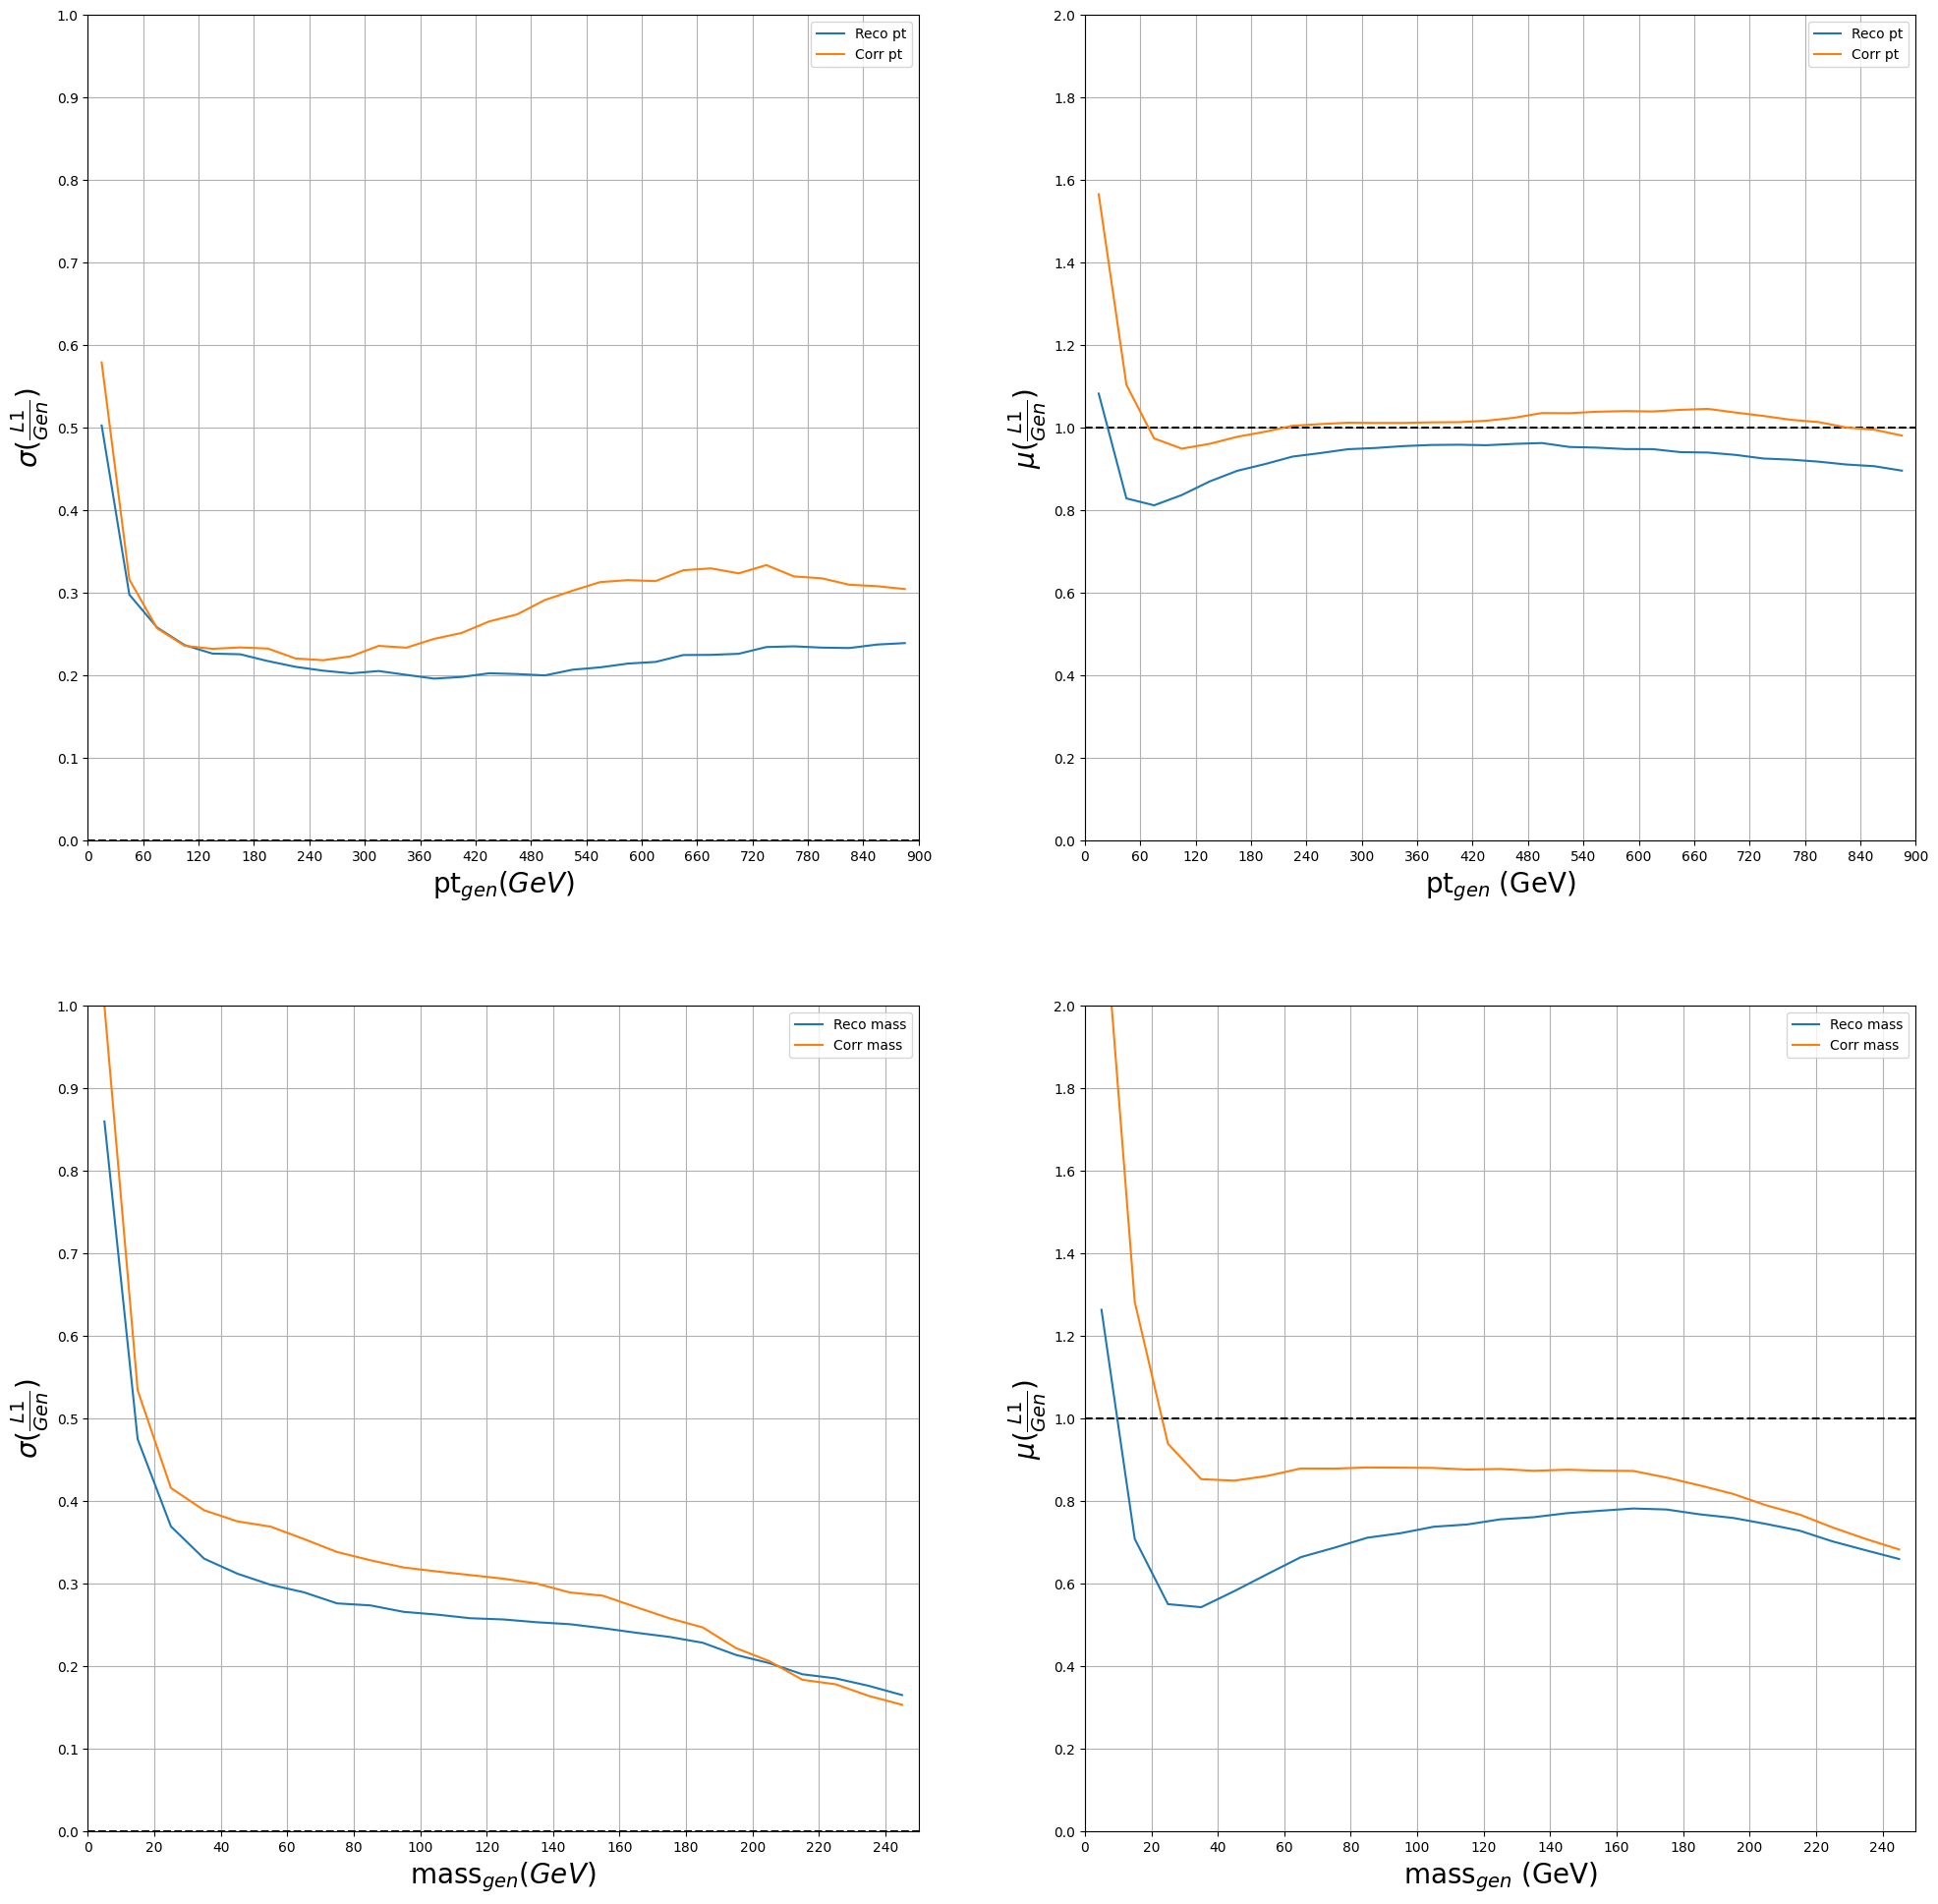

In [ ]:
plotResp(ptraw_df)

In [ ]:
ptphys = Jet(path, "pt_phys", "eta_phys")
ptphys_df = ptphys.pipeline()

Loading L1 data with pt == pt_phys and eta == eta_phys...
L1 data loaded.

Loading gen data...
Gen data loaded.

Rejecting jets marked as bad...
Rejected 18462 jets marked as bad.
Total jets = 7815073


Removing 2102690 unmatched jets in dataset...
5712383 jets remaining in dataset


Removing 1347175 jets due to level-1 cuts...
4365208 jets remaining in dataset.


Shuffling jets...
Jets shuffled.


Splitting jets into training and testing samples...
Allocated 3273906 jets for training, and 1091302 jets for testing


Calculating pT and mass response...
pT and mass response calculated and appended to data.

Binning with respect to gen pT, eta and mass, with bins populated with mean pT response and mean mass response...
Binning complete.

Calculating scale factors from mean response, imputing 1 for nans...
Scale factors saved.


Applying scale factors to get corrected pT and mass...
Corrected pT and mass saved.


Producing a dataframe from test data...
Dataframe produced.




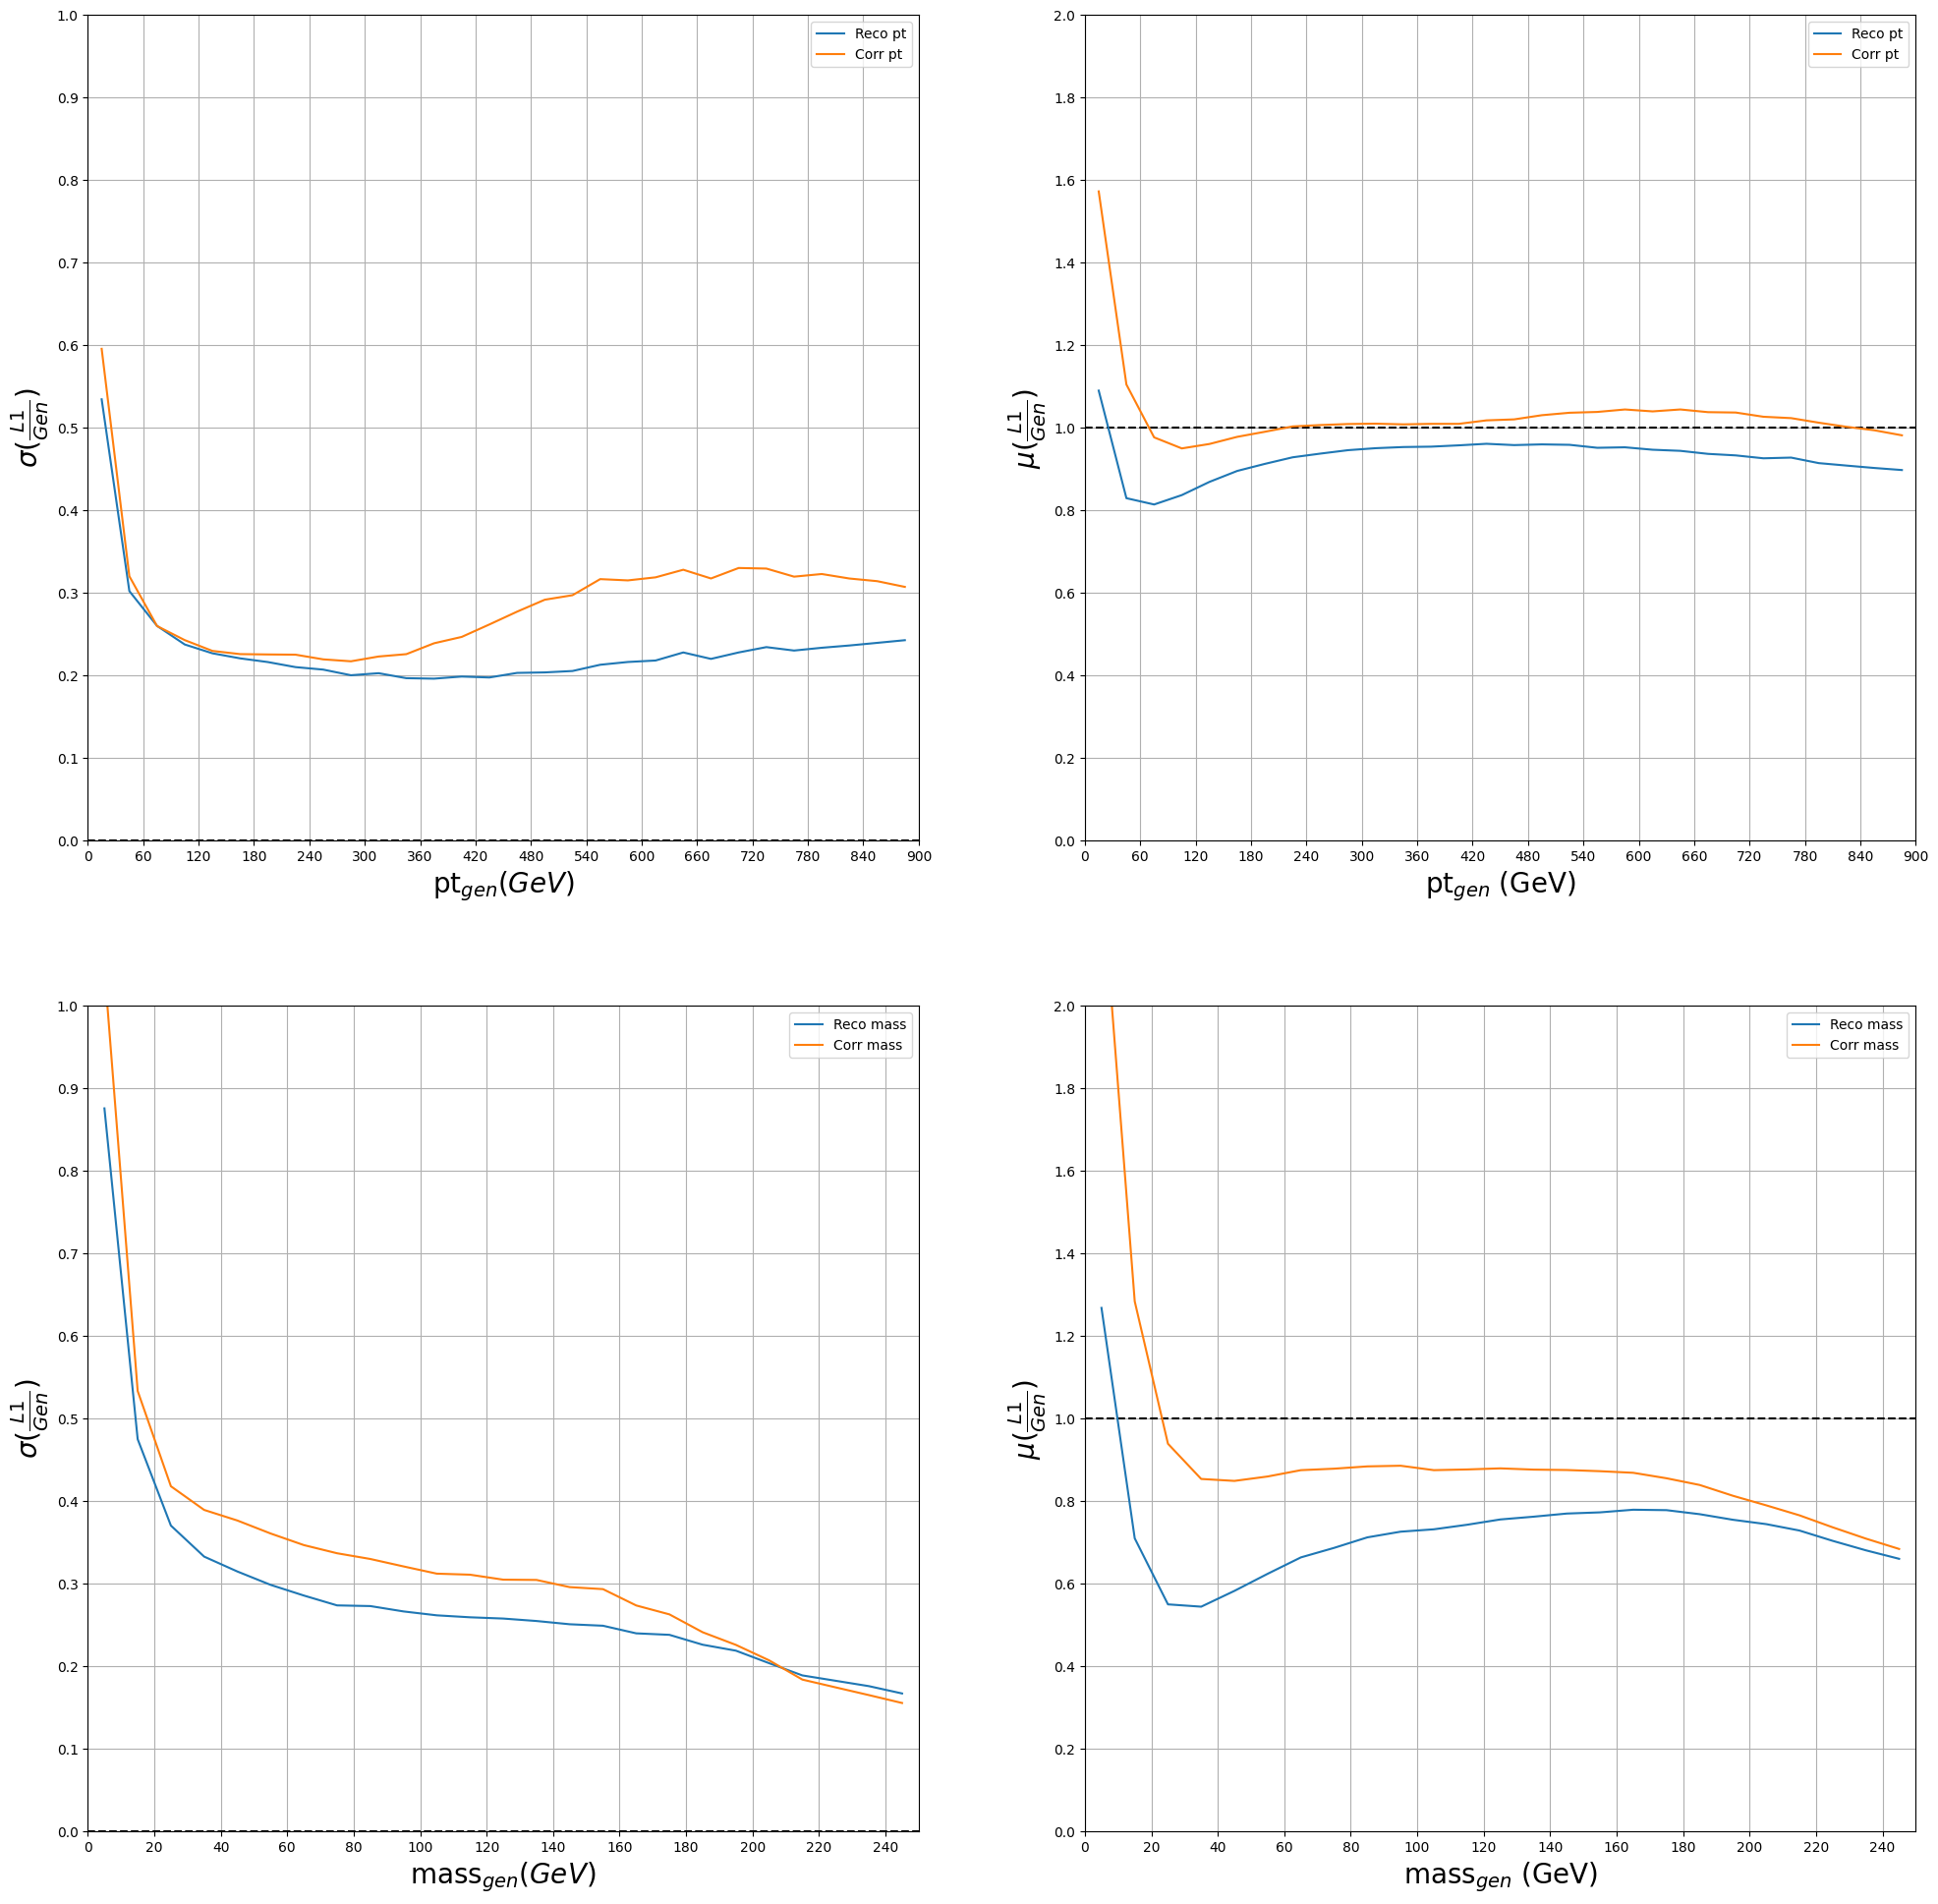

In [ ]:
plotResp(ptphys_df)

In [ ]:
ptcorr = Jet(path, "pt_corr", "eta_phys")
ptcorr_df = ptcorr.pipeline()

Loading L1 data with pt == pt_corr and eta == eta_phys...
L1 data loaded.

Loading gen data...
Gen data loaded.

Rejecting jets marked as bad...
Rejected 18462 jets marked as bad.
Total jets = 7815073


Removing 2102690 unmatched jets in dataset...
5712383 jets remaining in dataset


Removing 1318006 jets due to level-1 cuts...
4394377 jets remaining in dataset.


Shuffling jets...
Jets shuffled.


Splitting jets into training and testing samples...
Allocated 3295782 jets for training, and 1098595 jets for testing


Calculating pT and mass response...
pT and mass response calculated and appended to data.

Binning with respect to gen pT, eta and mass, with bins populated with mean pT response and mean mass response...
Binning complete.

Calculating scale factors from mean response, imputing 1 for nans...
Scale factors saved.


Applying scale factors to get corrected pT and mass...
Corrected pT and mass saved.


Producing a dataframe from test data...
Dataframe produced.




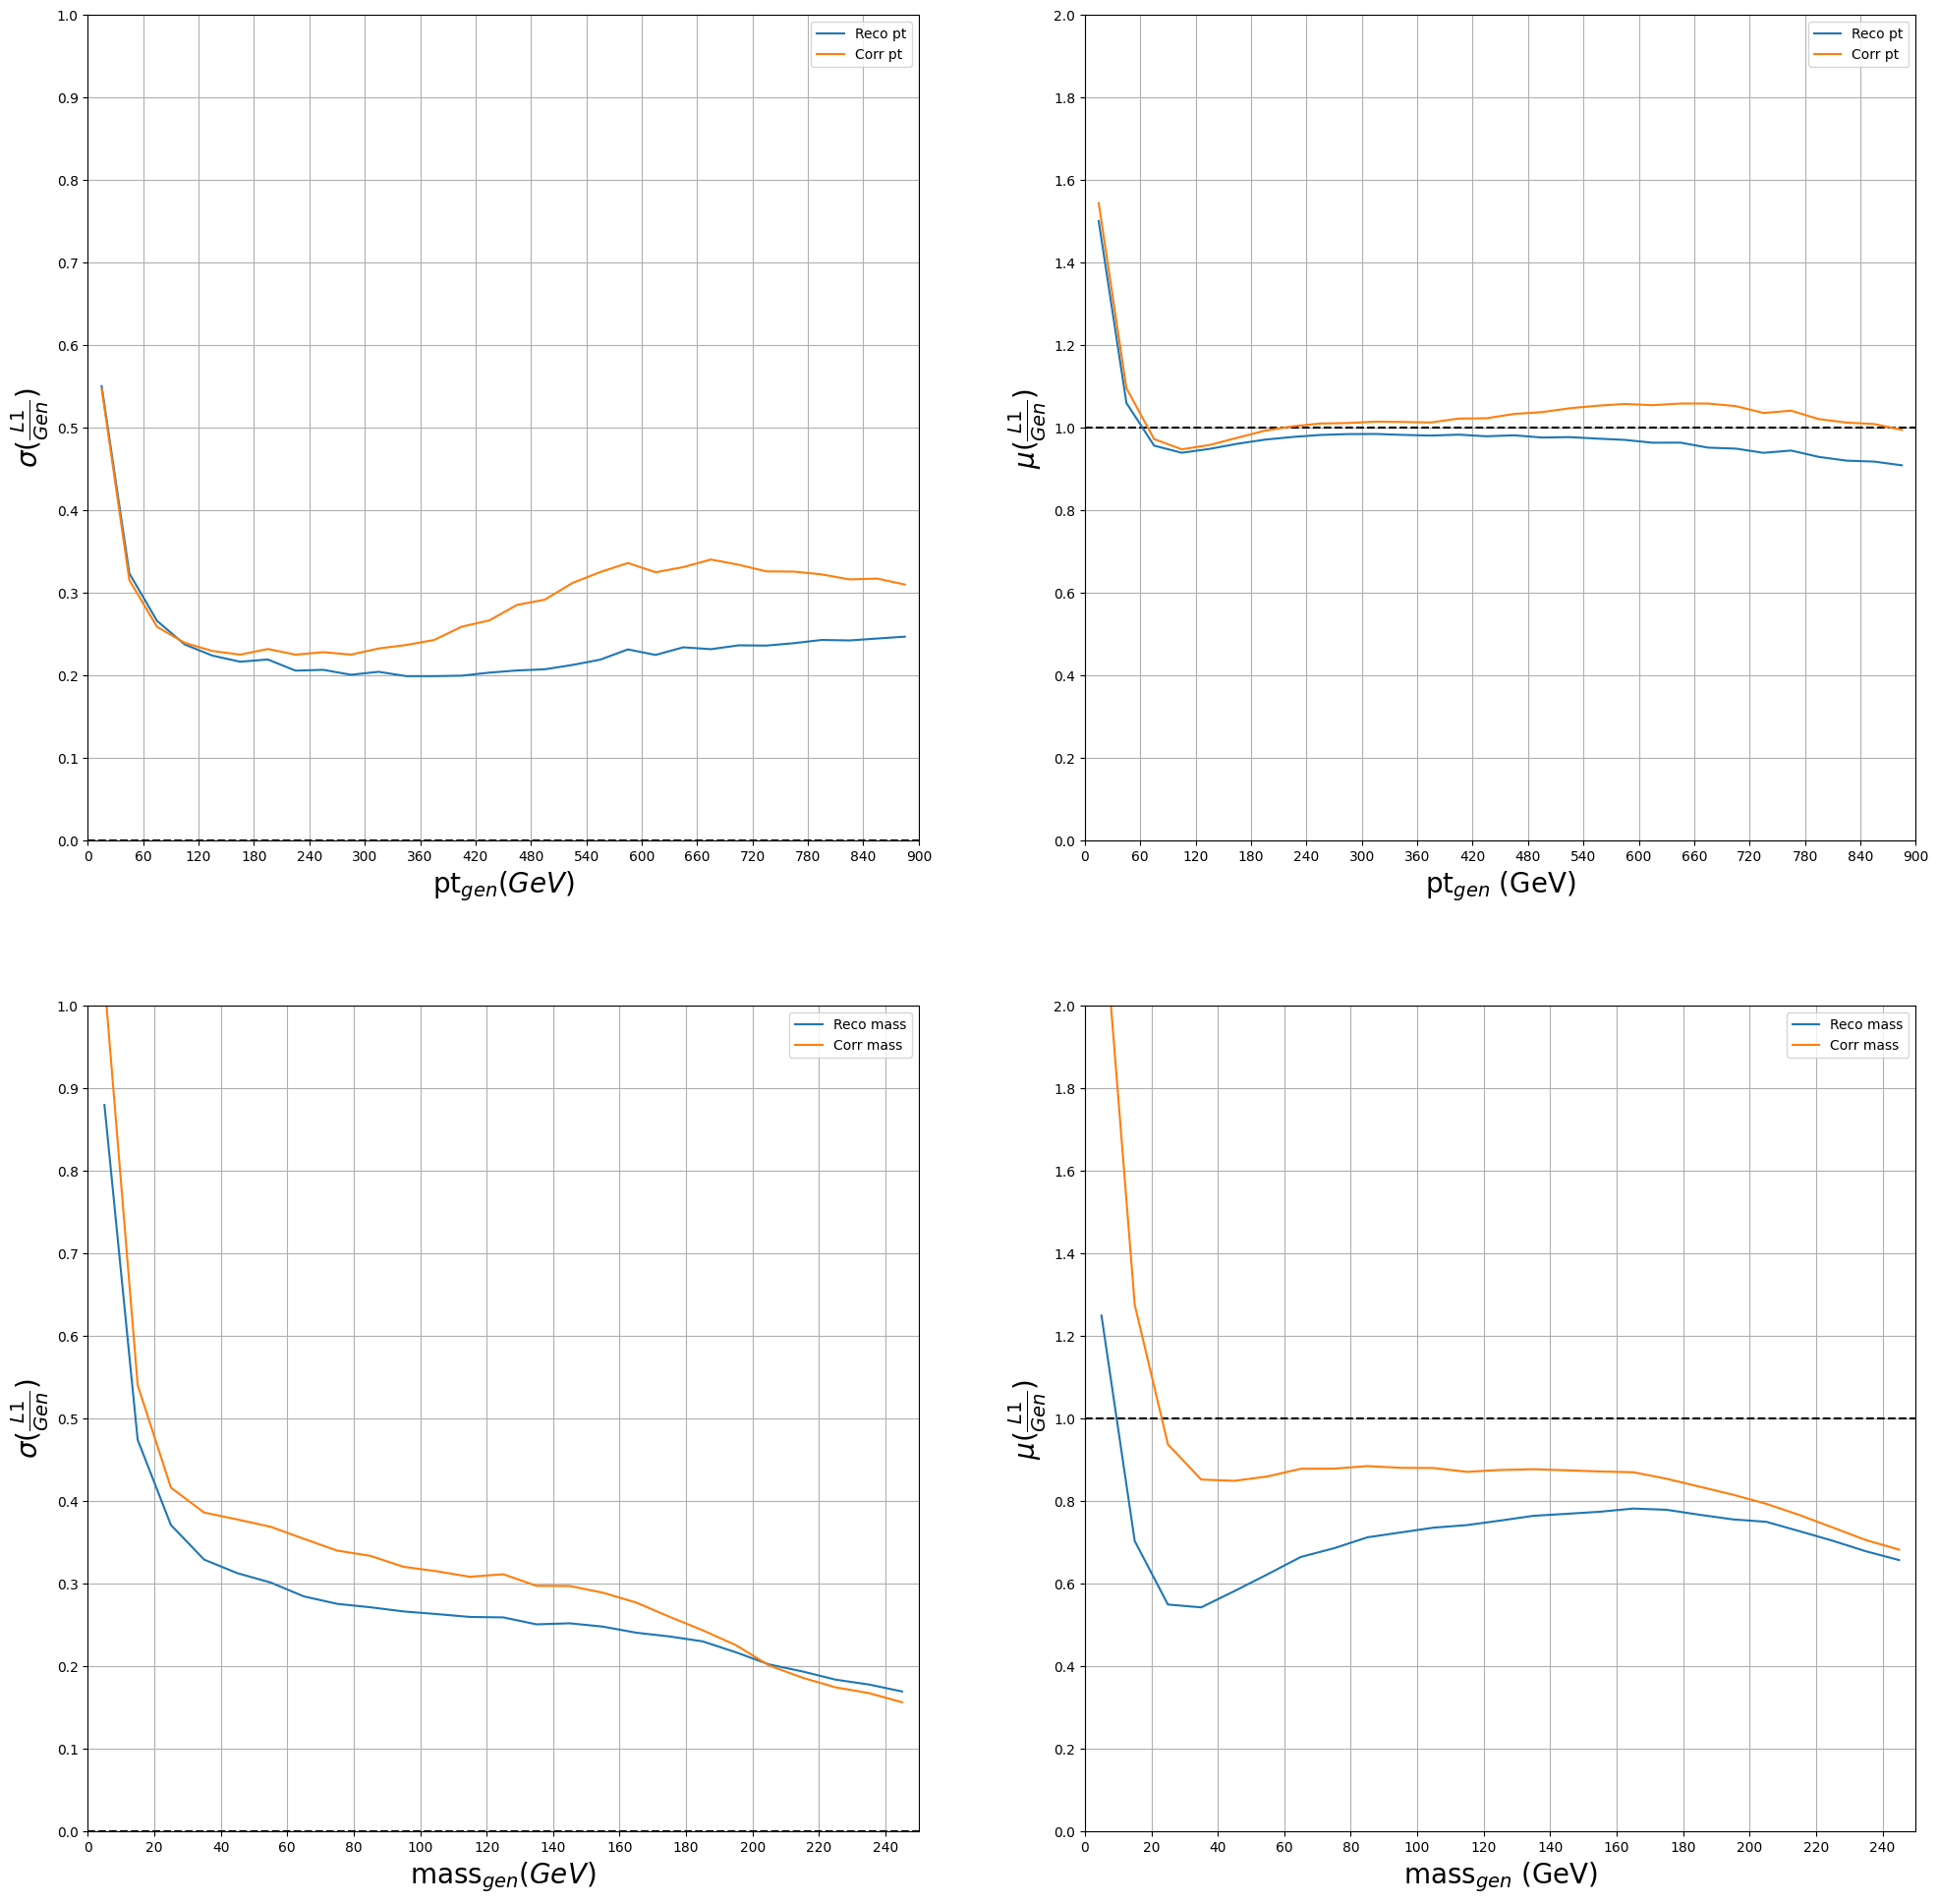

In [ ]:
plotResp(ptcorr_df)

# Plot scale factors

In [ ]:
plt.figure(figsize=(12,8))

plt.imshow(np.mean(stat_pt, axis=1), origin="lower", aspect="auto",
           extent=[0, 200, 0, 1000],
           cmap="viridis")

plt.colorbar(label="Average Scale Factor")
plt.xlabel("Mass")
plt.ylabel("pT")
plt.title("Scale Factor averaged over eta")
plt.show()

NameError: name 'stat_pt' is not defined

<Figure size 1200x800 with 0 Axes>